In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

This ipython notebook will illustrate the matching methodology we will use to match patients in the SEER-Medicare linked database. The comparison between patient outcomes between those patients who receive proton beam therapy vs traditional radiation therapy requires as a first step a matching of the two different groups. One method to perform this matching is to use Propensity Score Matching. Here we are going to illustrate a more direct method of matching using KDTrees, a data structure that allows for efficient finding of nearest neighbors in high-dimenional space.


We will illustrate the medthodology by using it in the 
latest release of the SEER data. We will take in the colon cancer patient data, and treat the male and female patients as the treatment and control groups, respectively. We will perform the patient matching and show the overall improvement in coviarate balancing that results. We will then ask two questions: "Are Males or Females more likely to be uninsured?" (A discrete outcome; use Bayesian A/B testing), and "Are Male or Female colon cancer patients more likely to live at higher elevation?" (A question involving distributions; answered by sampling repeatedly from the empirical CDFs for both the treatment and control groups).

In [5]:
import seerhelp

colorectfiles = seerhelp.get_colorectfiles()
colorectfiles

['SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\COLRECT.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\COLRECT.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\COLRECT.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\COLRECT.txt']

In [6]:
dfcolon0 = seerhelp.make_clean_dataframe(colorectfiles[0])

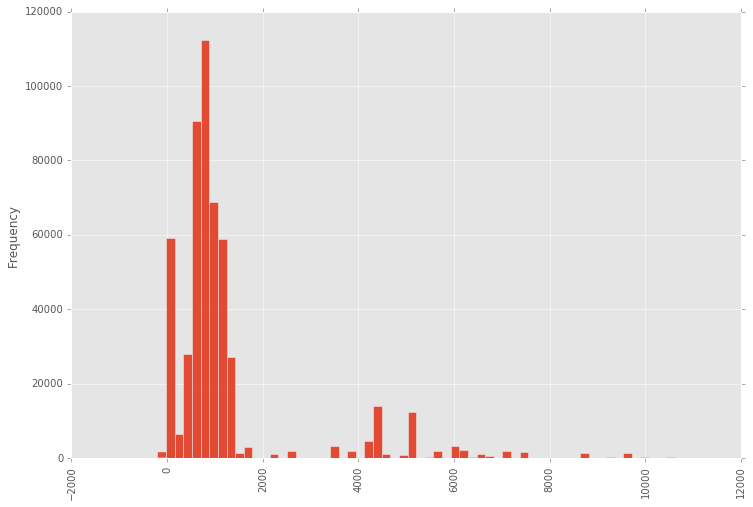

In [8]:
dfcolon0['elevation'].plot(kind='hist',bins=60,rot=90,figsize=((12,8)));

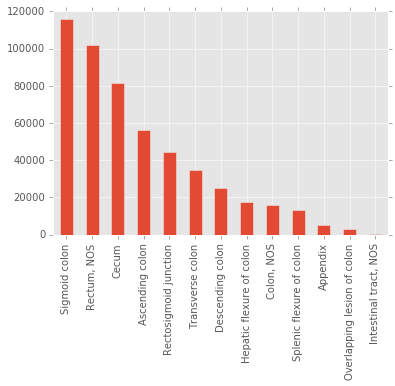

In [11]:
dfcolon0['PRIMSITE'].value_counts().plot(kind='bar',rot=90);


## <font color='purple'>One-Hot Encode the categorical variables we wish to include

In order to find the nearest neighbors in the high-dimensional feature space, we need to first do soem preprocessing of the data. The first step is to "one-hot encode" the categorical features.

In [12]:

mask = (dfcolon0['CSTUMSIZ'] != "Unknown; size not stated; not stated in patient record") & \
 (dfcolon0['CSTUMSIZ'] != "Microscopic focus or foci only; no size of focus is given") & \
 (dfcolon0['CSTUMSIZ'] != "989 millimeters or larger") & \
 (dfcolon0['CSTUMSIZ'] != "Not applicable") & \
 (dfcolon0['AGE_DX'] != "Unknown age") & \
 (dfcolon0['srv_time_mon_flag'] == "Complete dates are available and there are more than 0 days of survival") & \
 (dfcolon0['REC_NO'] == 1) & \
 (dfcolon0['YEAR_DX'] >= 2004) & \
 (dfcolon0['CSTUMSIZ'] != "Described as less than 1 cm") & \
(dfcolon0['CSTUMSIZ'] != "Described as less than 2 cm") & \
(dfcolon0['CSTUMSIZ'] != "Described as less than 3 cm") & \
(dfcolon0['CSTUMSIZ'] != 'Indicates no msas or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfcolon0['CSTUMSIZ'] != "Described as less than 4 cm") & \
(dfcolon0['CSTUMSIZ'] != "Described as less than 5 cm") & \
(dfcolon0['CSTUMSIZ'] != "Not applicable") & \
(dfcolon0['YR_BRTH'] != 'Unknown year of birth') & \
(dfcolon0['CSTUMSIZ'] != 'Not applicable') & \
(dfcolon0['CSTUMSIZ'] != 996) & \
(dfcolon0['CSTUMSIZ'] != 997) & \
(dfcolon0['CSTUMSIZ'] != 998)

In [13]:
dfsmall = dfcolon0[mask].copy()

In [14]:
dfsmall.shape

(74179, 141)

In [15]:
dfsmall.SEX.value_counts()

Male      37606
Female    36573
Name: SEX, dtype: int64

## <font color='purple'>Treatment and Control group definitions</font>

Let's consider ```(dfsmall.SEX == "Male")``` as the **treatment** group and 
```(dfsmall.SEX == "Female")``` as the **control** group. We need to match patients in the tratment group with those in the control group.